In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

In [3]:
print('y.head()')
y.head()


y.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
#  Encoders

ordinal_label_encoder_pipe = Pipeline([

    ('label-encoder', OrdinalEncoder(cols=config.categorical)),
    ('quasy_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler()),
    # ('regressor', BayesianRidge())
])

In [5]:
print("test_set")
test_set.head()


test_set


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [6]:
# split for starspace and catboost datasets
X.replace(to_replace=config.ordinal_to_replace, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

In [7]:
X_hyper_encoder = ordinal_label_encoder_pipe.fit(X=X)
X_hyper_values = X_hyper_encoder.transform(X).astype(dtype=str)
X_hyper = pd.DataFrame(data=X_hyper_values, index=X.index, columns=X.columns)

/home/sergey/anaconda3/envs/ml_advanced_project/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [8]:
ordinal_encoder = ordinal_label_encoder_pipe.fit(X=X_train)
X_train = pd.DataFrame(data=ordinal_encoder.transform(X_train),
                 index=X_train.index,
                 columns=X_train.columns).astype(int, errors='ignore')
X_train = X_train.astype(dtype=str)

# X_train
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_train.dtypes != int))

/home/sergey/anaconda3/envs/ml_advanced_project/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
X_test = pd.DataFrame(data=ordinal_encoder.transform(X_test),
                 index=X_test.index,
                 columns=X_test.columns).astype(int, errors='ignore')
X_test = X_test.astype(dtype=str)

# print('X_test')
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_test.dtypes != int))

In [10]:
test_set.replace(to_replace=config.ordinal_to_replace, inplace=True)
test_set = pd.DataFrame(data=X_hyper_encoder.transform(test_set),
                 index=test_set.index,
                 columns=test_set.columns).astype(int, errors='ignore')

test_set = test_set.astype(str)


In [11]:
h1n1_train_counts = y.h1n1_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов")
print(f"h1n1_train_counts train \n {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов
h1n1_train_counts train 
 [21033  5674] 0.26976655731469595


In [12]:

def hyperopt_ctb_score(params):
    
    global global_hyperopt_counter
    global train_set
    global val_set
    
    global_hyperopt_counter  += 1
    
    clf = CatBoostClassifier(**params)
    
#     fit_params = {
#         'eval_set': 1,
#         'use_best_model': True
#     }
    
#     current_validation = cross_validate(
#         estimator=clf,
#         X=X_hyper,
#         y=y_hyper,
#         cv=3,
#     )

    # current_score = current_validation['test_score'].mean()

    clf.fit(X=train_set, eval_set=val_set, use_best_model=True)
    current_score = clf.get_best_score()['validation']['AUC']
    # print('current_score', current_score)
    result = {
        'loss': -current_score,
        'status': STATUS_OK,

        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'model': 'model'}
    }
    
    # if global_hyperopt_counter % 10 == 0:
    print('*****  iterations ', global_hyperopt_counter)
        
    return result

catboost_space = {

    # 'grow_policy': hp.choice('grow_policy', ['Lossguide', 'Depthwise']), # 'SymmetricTree',  #  'Depthwise',
    # 'auto_class_weights': hp.choice('auto_class_weights', ['SqrtBalanced','Balanced']),
    # 'langevin': True,  # CPU only
    # 'learning_rate': hp.quniform('learning_rate', 4e-3, 3e-2, 1e-3),
    'depth':  hp.choice('depth', np.arange(5, 24, dtype=int)),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1e-1, 3e2, 1e1),
    'max_leaves': hp.choice('max_leaves', np.arange(5, 64, dtype=int)),  
    'border_count': hp.choice('border_count', np.arange(64, 256, dtype=int)), 

    'random_strength': hp.quniform('random_strength', 1e-3, 8e-1, 1e-2), 
    'bagging_temperature': hp.quniform('bagging_temperature', 1e-3, 8e-1, 1e-2), 
}

In [13]:
%%time 

# Hyperopt main loop

global_hyperopt_counter = 0
hyper_best_params = {}
for col in y.columns:
    # y_hyper = y[col]
    train_set = Pool(data=X_train, label=y_train[col], cat_features=X_train.columns)
    val_set = Pool(data=X_test, label=y_test[col], cat_features=X_test.columns)

    hyperopt_local_params = config.params.copy()
    hyperopt_local_params.update(catboost_space)

    trials = Trials()
    best = fmin(fn=hyperopt_ctb_score, space=hyperopt_local_params, algo=tpe.suggest, max_evals=2, trials=trials, verbose=False)
    print('best:', col)
    print(best)
    hyperopt_local_params.update(best)
    hyper_best_params[col] = hyperopt_local_params

0:	learn: 0.7093366	test: 0.7028334	best: 0.7028334 (0)	total: 96.4ms	remaining: 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8391054054
bestIteration = 13

Shrink model to first 14 iterations.
*****  iterations  1
0:	learn: 0.7094114	test: 0.7034833	best: 0.7034833 (0)	total: 47.5ms	remaining: 11.8s
249:	learn: 0.8357702	test: 0.8421657	best: 0.8422169 (247)	total: 9.61s	remaining: 0us

bestTest = 0.8422169232
bestIteration = 247

Shrink model to first 248 iterations.
*****  iterations  2
best: h1n1_vaccine
{'bagging_temperature': 0.22, 'border_count': 87, 'depth': 18, 'l2_leaf_reg': 140.0, 'max_leaves': 2, 'random_strength': 0.39}
0:	learn: 0.7912954	test: 0.7905773	best: 0.7905773 (0)	total: 90.7ms	remaining: 22.6s
249:	learn: 0.8589176	test: 0.8433664	best: 0.8433664 (249)	total: 19.3s	remaining: 0us

bestTest = 0.8433663775
bestIteration = 249

*****  iterations  3
0:	learn: 0.7784138	test: 0.7792665	best: 0.7792665 (0)	total: 48.5ms	remaining: 12.1s
24

In [14]:
# model training
models = {}
for col in y.columns:
    train_set = Pool(data=X_hyper, label=y[col], cat_features=X_hyper.columns)
    params = hyper_best_params[col]

    model = CatBoostClassifier(**params)
    model.fit(train_set)

    models[col] = model
print('model training ok')

0:	learn: 0.6933169	total: 43.3ms	remaining: 10.8s
249:	learn: 0.8157878	total: 9.35s	remaining: 0us
0:	learn: 0.7934194	total: 103ms	remaining: 25.6s
249:	learn: 0.8566495	total: 21.8s	remaining: 0us
model training ok


h1n1_vaccine
h1n1_concern 0.0
h1n1_knowledge 0.0
behavioral_antiviral_meds 0.0
behavioral_avoidance 0.0
behavioral_face_mask 0.0
behavioral_wash_hands 0.0
behavioral_large_gatherings 0.0
behavioral_outside_home 0.0
behavioral_touch_face 0.0
doctor_recc_seasonal 0.0
chronic_med_condition 0.0
child_under_6_months 0.0
health_worker 0.0
opinion_h1n1_sick_from_vacc 0.0
opinion_seas_vacc_effective 0.0
opinion_seas_risk 0.0
opinion_seas_sick_from_vacc 0.0
age_group 0.0
education 0.0
race 0.0
sex 0.0
income_poverty 0.0
marital_status 0.0
rent_or_own 0.0
employment_status 0.0
hhs_geo_region 0.0
census_msa 0.0
household_adults 0.0
household_children 0.0
employment_industry 0.0
employment_occupation 0.0
seasonal_vaccine
behavioral_antiviral_meds 0.005743533115629599
behavioral_face_mask 0.007453482187044839


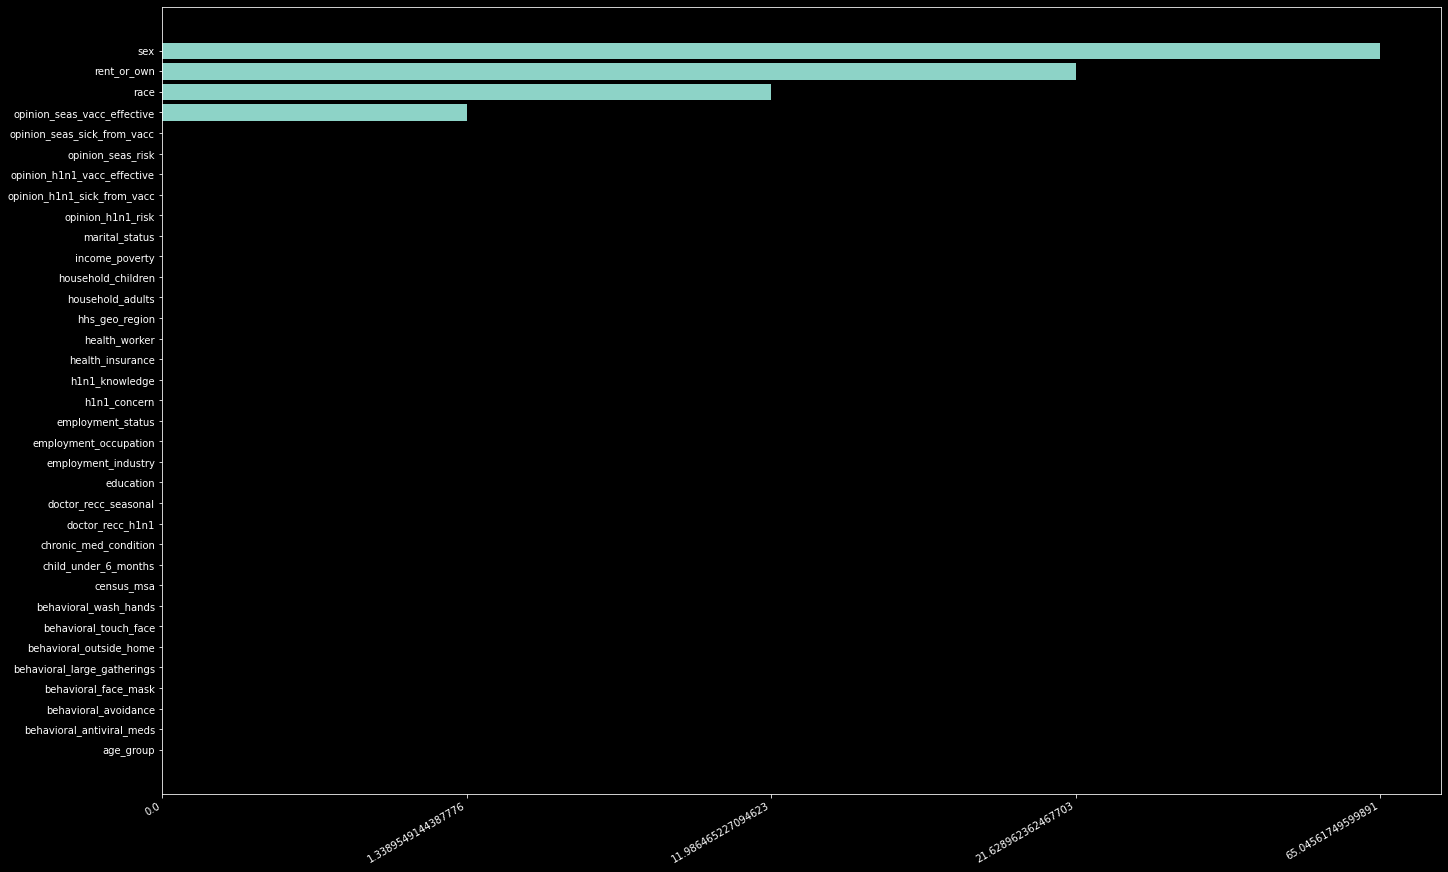

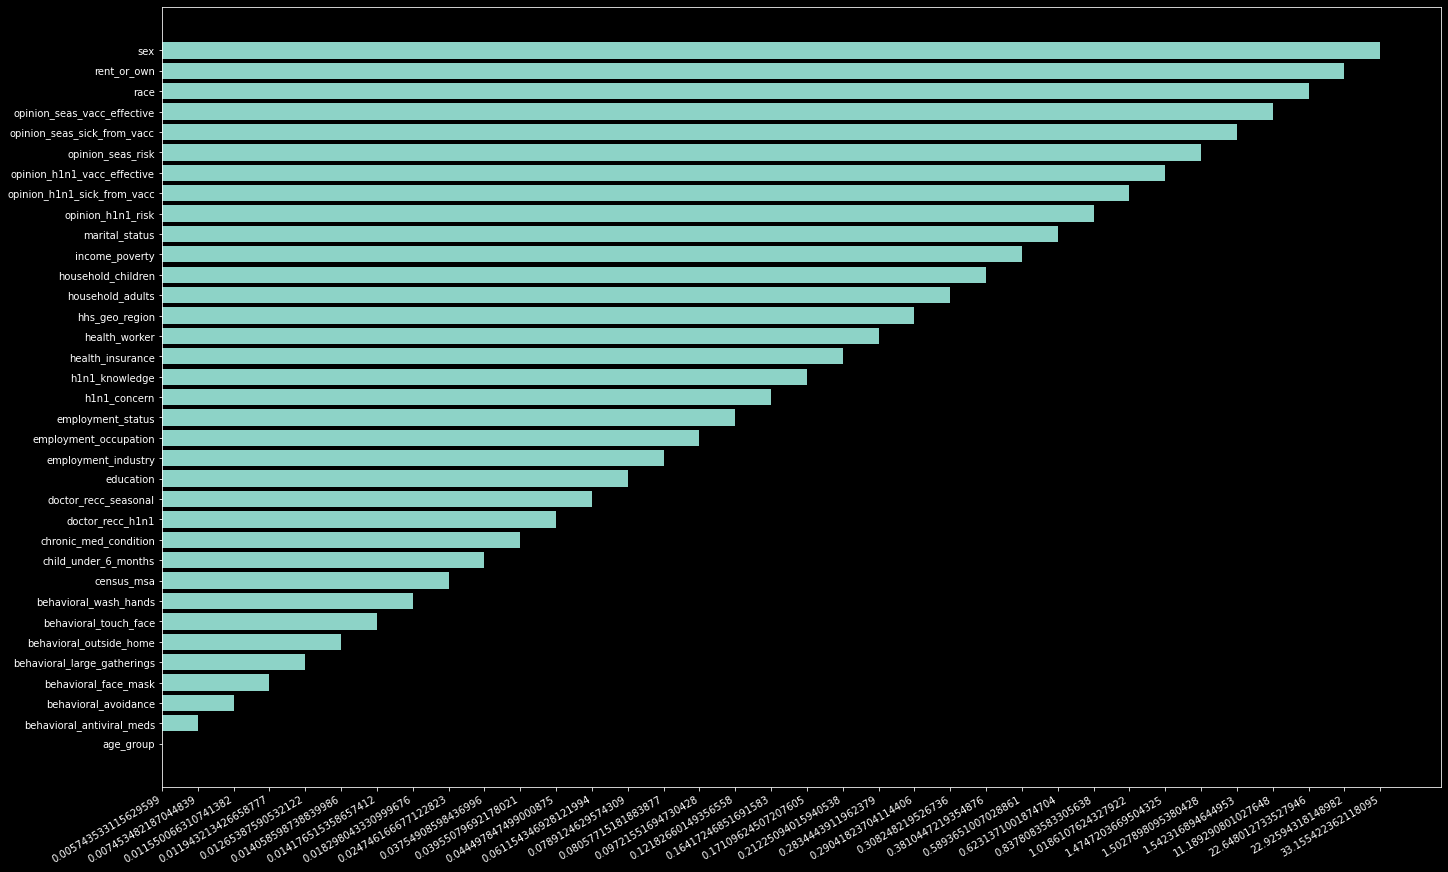

In [15]:
for model_name, model in models.items():
    print(model_name)
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(20, 12), constrained_layout=True);
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right");


In [16]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)

for col, model in models.items():
    test_pool = Pool(test_set, cat_features=test_set.columns)
    submission_df[col] = model.predict_proba(test_pool)[:, 1]

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.248347          0.306339
26708              0.218276          0.226804
26709              0.281629          0.648179
26710              0.442017          0.733114
26711              0.248347          0.587992


In [17]:
plt.hist(submission_df.h1n1_vaccine, bins=30);

,h1n1_vaccine,seasonal_vaccine
count,26708.000000,26708.000000
mean,0.289338,0.476112
std,0.094846,0.194446
min,0.218276,0.220739
25%,0.218276,0.272387
50%,0.244723,0.458860
75%,0.308504,0.677043
max,0.526566,0.767414


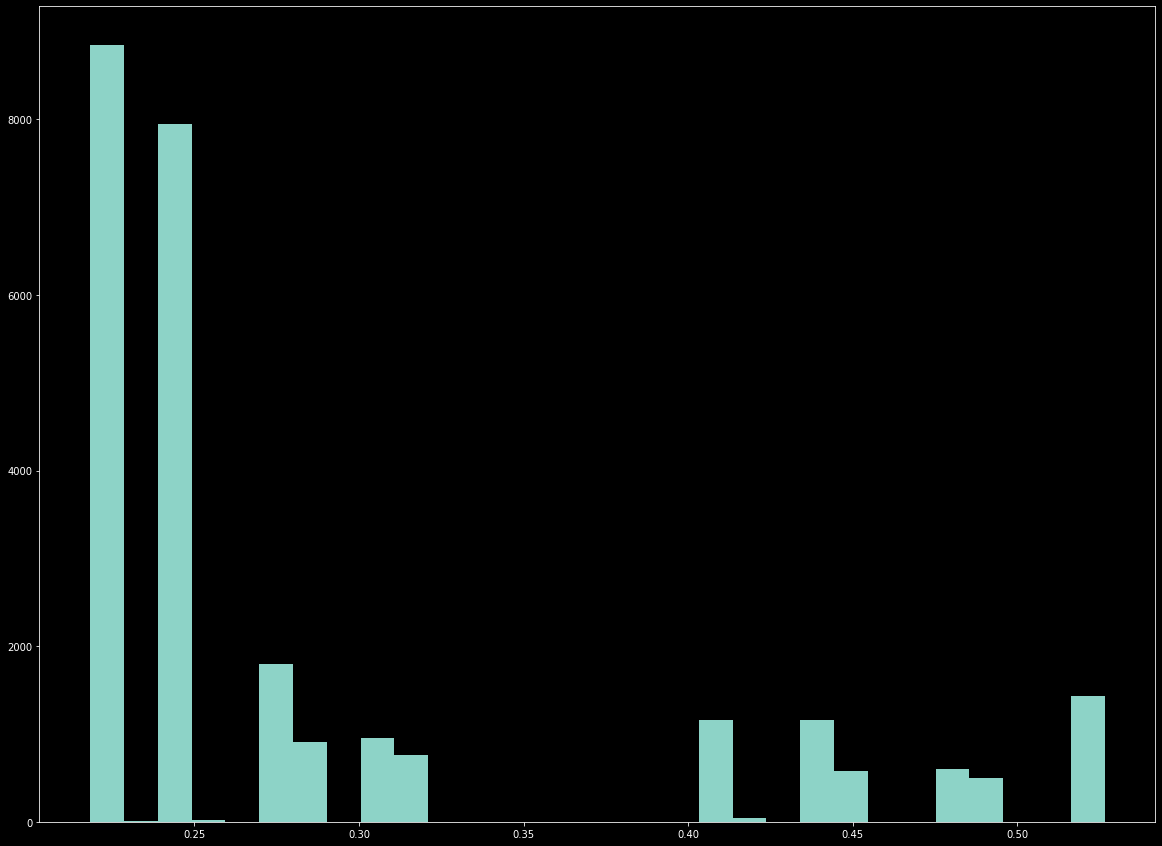

In [18]:
plt.hist(submission_df.seasonal_vaccine, bins=30);


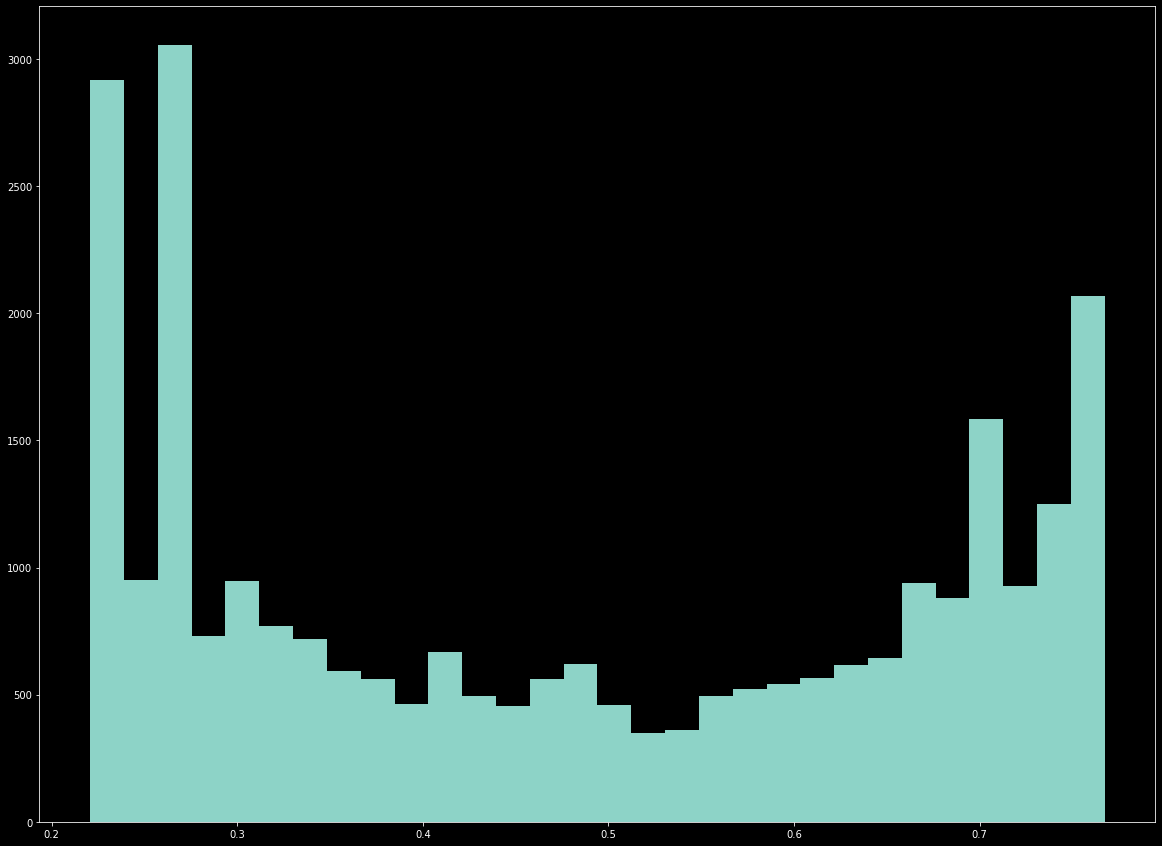

In [19]:
submission_df.to_csv("./flu_submission1.csv")

In [20]:
print('*********   FINISH  ************')


